In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from peewee import *
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

%load_ext autoreload
%autoreload 2

# load the glove vectors from the text file
# and save them in a numpy array
def load_glove_vectors(path):
    glove_dict = {}
    with open(path, 'r') as f:
        for line in f:
            line = line.strip().split()
            glove_dict[line[0]] = np.array(line[1:], dtype=np.float32)
    return glove_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
glove_mem = load_glove_vectors('glove.6B.300d.txt')

In [36]:
from glove_db import Glove
glove = Glove('./')
glove.vector('dog')

AttributeError: 'str' object has no attribute 'vector'

In [ ]:
same = []
for word in tqdm.tqdm(glove_mem):
    same.append(np.all(glove.vector('dog') == glove_mem['dog']))
print(np.all(same))

In [18]:
# define DB name
db = SqliteDatabase('glove.db')

# models
class BaseModel(Model):
    class Meta:
        database = db

# highest level, root node
class Word(BaseModel):
    word = CharField(unique=True)
    vector = CharField()

db.connect()
db.create_tables([Word], safe = True)
db.close()

import tqdm
for word in tqdm.tqdm(glove):
    word_db = Word(word=str(word), vector=','.join(glove['dog'].astype(str)))
    word_db.save()

100%|██████████| 400000/400000 [04:28<00:00, 1491.93it/s]


In [40]:
words = ['africa', 'ring', 'dog', 'earth', 'cat', 
         'apple', 'chair', 'table', 'book', 'pen', 
         'computer', 'phone', 'guitar', 'car', 'house', 
         'tree', 'flower', 'water', 'air', 'fire', 
         'sun', 'moon', 'star', 'sky', 'cloud']

# get vectors for each word
vectors = []
for word in words:
    vectors.append(glove[word])
vectors = np.array(vectors)

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
(25, 25)
cat 0.28097135
book 0.66469324
house 0.7114701
car 0.7207995
pen 0.7437154
tree 0.76180005
table 0.7736581
phone 0.7751636
ring 0.7895328
star 0.794706


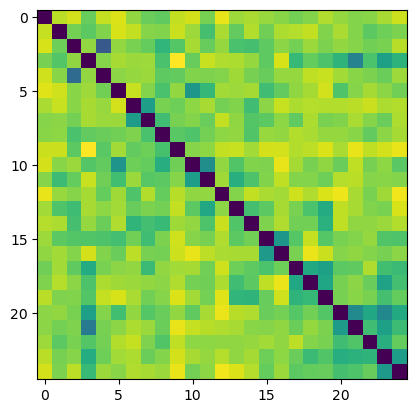

In [41]:
dists = vectors @ vectors.T
dists = 1 - dists / (np.linalg.norm(vectors, axis=1) * np.linalg.norm(vectors, axis=1))
print(dists.shape)
plt.imshow(dists)

# sort the words by their distance to the word and print the top 10
word = 'dog'
word_idx = words.index(word)
word_dists = dists[word_idx]
word_idxs = np.argsort(word_dists)
for i in range(1, 11):
    print(words[word_idxs[i]], word_dists[word_idxs[i]])

In [48]:
clusters = cluster_words(words)
for cluster in clusters:
    print(cluster)

['dog', 'cat'], 0.52
['earth', 'moon'], 0.69
['apple', 'computer'], 0.86
['sun', 'sky'], 0.86
['chair', 'table'], 0.88
['tree', 'flower'], 0.88
['water', 'fire'], 0.95
['air', 'water', 'fire'], 0.95
['cloud', 'sun', 'sky'], 0.96
['phone', 'car'], 0.96
['book', 'house'], 1.1
['ring', 'star'], 1.14
['earth', 'moon', 'cloud', 'sun', 'sky'], 1.14
['chair', 'table', 'book', 'house'], 1.23
['pen', 'guitar'], 1.33
['apple', 'computer', 'phone', 'car'], 1.35
['africa', 'ring', 'star'], 1.39
['tree', 'flower', 'africa', 'ring', 'star'], 1.53


In [22]:
all_clue_words = []
all_clue_vectors = []
for word in np.load(os.path.join('./', 'all_clue_words.npy')):
    if word.lower() in glove:
        all_clue_words.append(word.lower())
        all_clue_vectors.append(glove[word.lower()])
all_clue_words = np.array(all_clue_words)
all_clue_vectors = np.array(all_clue_vectors)

all_clue_words.shape

(29647,)

In [ ]:
def no_word_overlap(word, words):
        # make sure the word does not equal,
        # or is not a substring of any of the words, and vice versa
        return (word not in words) and (not any([word in w for w in words]) and (not any([w in word for w in words])))


class _Leaf(object):
    def __init__(self, word):
        self.lemma = word
    
    def __str__(self):
        return self.lemma


class _Cluster(object):
    def __init__(self, distance, children):
        self.distance = distance
        self.children = children
        self.lemmas = []
    
    def get_lemmas(self):
        # populate the lemmas array if it is empty
        if len(self.lemmas) == 0:
            for child in self.children:
                if isinstance(child, _Leaf):
                    self.lemmas.append(child.lemma)
                else:
                    self.lemmas.extend(child.get_lemmas())
        return self.lemmas
    
    def __str__(self):
        return str(self.get_lemmas()) + ', ' + str(np.round(self.distance, 2))


# create a proper tree structure,
# where each node has the average distance of its children
def convert_to_tree(pairs, words):
    leaves = {}
    clusters = {}

    for i, row in enumerate(pairs):
        if row[0] < len(words):
            # if it is an original point read it from the centers array
            a = words[int(row[0])]
            a = _Leaf(a)
            leaves[row[0]] = a
        else:
            # other wise read the cluster that has been created
            a = clusters[int(row[0])]

        if row[1] < len(words):
            b = words[int(row[1])]
            b = _Leaf(b)
            leaves[row[1]] = b
        else:
            b = clusters[int(row[1])]

        # set a and b as children of the new node
        distance = row[2]
        cluster = _Cluster(distance, children=[a, b])

        clusters[1 + i + len(pairs)] = cluster
    return clusters


def cluster_words(words, max_cluster_size=5):
    # use the wordA.similarity(wordB) metric
    # to get a similarity matrix
    similarity_matrix = np.zeros((len(words), len(words)))
    for i in range(len(words)):
        vector_i = glove[words[i]]
        for j in range(len(words)):
            vector_j = glove[words[j]]
            similarity_matrix[i, j] =  cosine_similarity(vector_i, vector_j)
    condensed_similarity_matrix = pdist(similarity_matrix)
    # use the similarity matrix to cluster the words
    Z = linkage(condensed_similarity_matrix, 'ward')

    clusters = convert_to_tree(Z, words)

    # remove clusters that are too big and far apart
    clusters = {k: v for k, v in clusters.items() if len(v.get_lemmas()) <= max_cluster_size}
    #clusters = {k: v for k, v in clusters.items() if v.distance <= max_distance}
    return list(clusters.values())

In [92]:
words = np.random.choice(all_clue_words, 25, replace=False)

clusters = cluster_words(words)
for cluster in clusters:
    print(cluster)
print()

def generate_clue(words):
    vectors = np.array([glove[word.lower()] for word in words])

    # filter out clues that overlap with the words
    possible_clues = []
    possible_vectors = []
    for clue, vector in zip(all_clue_words, all_clue_vectors):
        if no_word_overlap(clue, words):
            possible_clues.append(clue)
            possible_vectors.append(vector)
    possible_clues = np.array(possible_clues)
    possible_vectors = np.array(possible_vectors)

    dists = possible_vectors @ vectors.T
    dists = 1 - dists / (np.expand_dims(np.linalg.norm(vectors, axis=1),0) * np.expand_dims(np.linalg.norm(possible_vectors, axis=1), 1))
    best_dists = np.sum(dists, axis=1) # - np.sum(your_dists, axis=1)
    clue_idxs = np.argsort(best_dists)[:10]
    return possible_clues[clue_idxs], best_dists[clue_idxs]


for cluster in clusters:
    words = cluster.get_lemmas()
    clues, dists = generate_clue(words)
    print(words, '-->', clues[:2], dists[:2])

['tailoring', 'tailor'], 0.66
['artwork', 'display'], 0.86
['creativity', 'boundless'], 0.95
['spyware', 'shampoos'], 1.07
['clam', 'sweets'], 1.25
['councillors', 'reformed'], 1.26
['scanner', 'spyware', 'shampoos'], 1.27
['promotion', 'resist'], 1.27
['phosphorus', 'crim'], 1.28
['skyscraper', 'pipe'], 1.31
['envoy', 'ceo'], 1.31
['misfortune', 'creativity', 'boundless'], 1.33
['gruber', 'envoy', 'ceo'], 1.41
['article', 'artwork', 'display'], 1.41
['overcrowding', 'councillors', 'reformed'], 1.43
['clam', 'sweets', 'phosphorus', 'crim'], 1.52
['promotion', 'resist', 'article', 'artwork', 'display'], 1.62
['tailoring', 'tailor', 'scanner', 'spyware', 'shampoos'], 1.87

['tailoring', 'tailor'] --> ['bespoke' 'carpentry'] [0.87149   1.2243845]
['artwork', 'display'] --> ['exhibit' 'paintings'] [0.8984322  0.92230827]
['creativity', 'boundless'] --> ['ingenuity' 'limitless'] [0.9306278 0.9427786]
['spyware', 'shampoos'] --> ['adware' 'lotions'] [0.9098205 1.0376933]
['clam', 'sweets'] -

In [37]:
import cluegen
clue_generator = cluegen.ClueGenerator(path='./')

ClueGenerator initialized


In [40]:
clusters = clue_generator.cluster_words(['tree', 'grass', 'lake', 'plant'])
for cluster in clusters:
    print(cluster)

#clue_generator.get_clue(['tree', 'grass', 'lake'])

['tree', 'grass'], 0.83
['plant', 'tree', 'grass'], 1.02
['lake', 'plant', 'tree', 'grass'], 1.27


In [26]:
# save all_clue_words and all_clue_vectors using numpy
np.save('all_clue_words.npy', all_clue_words)
np.save('all_clue_vectors.npy', all_clue_vectors)

In [27]:
import pickle
# save the glove vectors
glove_dict = {}
glove_vectors = []
with open('./glove.6B.300d.txt', 'r') as f:
    for i, line in enumerate(f):
        line = line.strip().split()
        glove_dict[line[0]] = i
        glove_vectors.append(np.array(line[1:], dtype=np.float32))
glove_vectors = np.array(glove_vectors)

# pickle the glove_dict and save the glove_vectors
with open('glove_dict.pkl', 'wb') as f:
    pickle.dump(glove_dict, f)
np.save('glove_vectors.npy', glove_vectors)

In [36]:
a = np.array([1,2,3,4,5])
a[~np.array([1,2,3])]

array([4, 3, 2])